# `III. Multipole Expansion` 
This .pynb file reads `./inter_results/field_result.pkl` generated by `./II_Field_Simulation.ipynb`, and analyzes the field distribution result. This analysis can be specific according to your own need. Here, as an example, we focus on multipole expansion coefficient. 

## (1) import electric field and set parameters for it.

In [1]:
import sys
sys.path.append('../../Electrodes')
import pickle
# add multipoles package path

from Electrodes.multipoles import MultipoleControl
from Electrodes.plottingfuncns import *
sys.path.append('../../helper_func')
from utils.helper_functions import *
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt
import matplotlib.pyplot as plt
import matplotlib.cm as cm
# module_path = os.path.dirname(os.path.abspath(__file__))
module_path = os.path.abspath('')

In [2]:
###### loading in pickle file ###############################
# import data, and define parameters
# path = module_path+'/inter_results/june-july_2022/taper_long.pkl'
path = module_path+'/inter_results/htrap_simulation_tall(rad=300um,inside=1e-4).pkl'
path = module_path+'/inter_results/htrap_simulation_super.pkl'
f = open(path, 'rb')
trap = pickle.load(f)
print(trap['electrodes'].keys())
#############################################################
e = 1.6*10**(-19)
m =40*1.66054*10**(-27)
RFfreq = 33.84*10**6*2*np.pi
voltage = 80
mmToM = 1000
scaling = mmToM**2*voltage**2*e/(4*m*RFfreq**2)
print("scalefactor")
print(scaling)
trap['electrodes']['RF']['potential'] = trap['electrodes']['RF']['potential']*scaling

dict_keys(['DC0', 'RF'])
scalefactor
0.08525310138297665


In [25]:

###### setting up multipole expansion @ trap location #######
#xl, yl, zl define the origin at which we will do the multipole expansion
#i.e. they define where you want to trap

#strs are the string names of your DC electrodes (copy from loading pickle,
#I wrote it a second time so that the code runs in case you comment out that code)
strs = "DC1 DC2 DC3 DC4 DC5 DC6 DC7 DC8 DC9 DC10 DC11 DC12 DC13 DC14 DC15 DC16 DC17 DC18 DC19 DC20 DC21 RF".split()
strs = "RF".split()

zl = 270*1e-3
xl = -3.75*1e-3
xl = -5e-3
xl = -10e-3
# xl = 0*1e-3
yl = 72.65*1e-3
# yl=100*1e-3



position = [xl, yl, zl]

#ROI = 'range of interest', I believe
#It defines the volume region over which multipole expansion will be performed.
#nROI is the number of points that make up the dimensions of the volume of the ROI
#I believe it ends up being the indices of the 3-d array that you index so it is dimensionless
nROI = 3
roi = [nROI, nROI, nROI]
order = 4

#controlled electrodes- this will define which electrodes will be used to control your trap
controlled_electrodes = []

## (2) set parameters for multipole expansion
notes:
* new from shuqi's code- 'excl' defines a dictionary of excluded electrodes the dictionary index (left of colon)  is the electrode you want to exclude its value (right of colon) defines what you want to set it to if you set it to "gnd" it will always set the voltage of that DC to 0 if you set it to "DCx" it will always set the voltage of that DC to be the same as DCx this is in case you have trap shorts, if you don't need it just don't include the indices

()
0.25
pseudo depth: 117.84323398303209mV


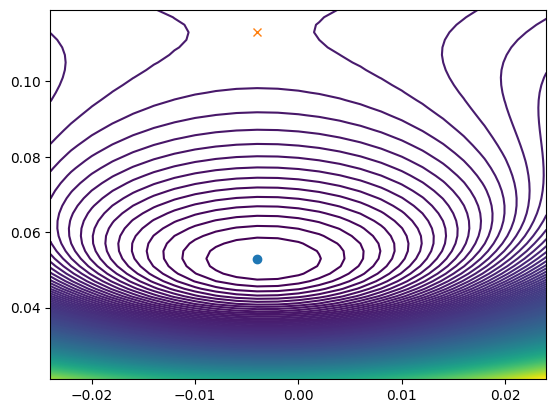

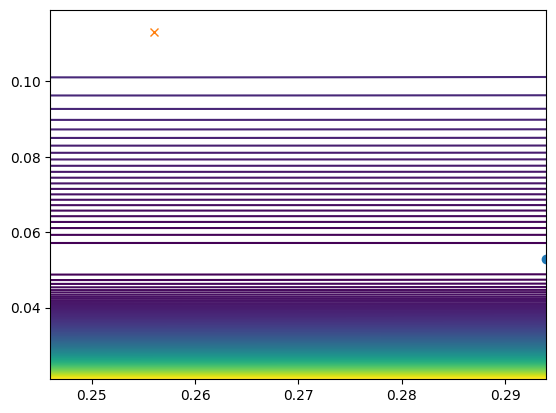

Multipole names: ['C', 'Ey', 'Ez', 'Ex', 'U3', 'U4', 'U2', 'U5', 'U1']
Normalization factors: [0.28209479 0.48860251 0.48860251 0.48860251 1.09254843 1.09254843
 0.63078313 1.09254843 0.54627422]


In [26]:
excl = {
    # "DC6": "gnd",
    #     "DC4": "gnd",
        # "DC5": "gnd",
    #     "DC8": "gnd",
    #     "DC14": "DC13",
        # "DC11": "gnd",
        # "DC12": "gnd",
#     "DC1": "gnd",
#     "DC19": "gnd",
    # "RF":"gnd"
}

#build the controlled electrodes list, given the constraints of the 'excl' list
# def generate_s(excl):
for electrode in strs:
    if electrode in excl and excl[electrode] != "gnd":
        trap['electrodes'][excl[electrode]]["potential"] = trap['electrodes'][excl[electrode]]["potential"] + \
                                                           trap['electrodes'][electrode]["potential"]
    elif electrode not in excl:
        controlled_electrodes.append(electrode)

print(np.shape(trap['electrodes']))


#which multipoles you want to include in multipole calculations
used_order1multipoles = ['Ex', 'Ey', 'Ez']
used_order2multipoles = ['U1', 'U2', 'U3','U4','U5']
used_multipoles = used_order1multipoles + used_order2multipoles
print(trap['Z'][2])


# create MultipoleControl object
s = MultipoleControl(trap, position, roi, controlled_electrodes, used_multipoles, order)
#     return s
# s,used_multipoles = generate_s(excl)
###############################################################
fig = plt.figure()
# ax = plt.axes(projection='3d')

d = trap['electrodes']['RF']['potential']
x,y,z= d.nonzero()
t = np.arange(100)
# ax.scatter(x, y, z, c=np.swapaxes(d,1,2), alpha=0.01,vmin=0,vmax=5,cmap = "viridis")
# ax.set_xlabel('x')
# ax.set_ylabel('y')
# ax.set_zlabel('z')
# ax.set_title('3D contour')
# plt.show()

field_min = find_saddle(d,trap['X'],trap['Y'],trap['Z'],dim=3, scale=1, Z0=zl,min=True)
field_saddle = find_saddle(d,trap['X'],trap['Y'],trap['Z'],dim=3, scale=1, Z0=zl,min=False)

minp = np.min(np.transpose(d[:,:,2]))
maxp= np.max(np.transpose(d[:,:,2]))
saddle_val = d[field_saddle[0],field_saddle[1],field_saddle[2]]
min_val = d[field_min[0],field_min[1],field_min[2]]
depth = (saddle_val-min_val)*1000

print("pseudo depth: {depth}mV".format(depth=depth))
plt.contour(trap['X'],trap['Y'],np.transpose(d[:,:,2]),levels=np.arange(minp,maxp,(maxp-minp)/200))
plt.plot(trap['X'][field_min[0]],trap['Y'][field_min[1]],marker='o')
plt.plot(trap['X'][field_saddle[0]],trap['Y'][field_saddle[1]],marker='x')
plt.show()

minp = np.min(np.transpose(d[int(len(d[:,0,0])/2),:,:]))
maxp= np.max(np.transpose(d[int(len(d[:,0,0])/2),:,:]))
plt.contour(trap['Z'],trap['Y'],d[int(len(d[:,0,0])/2),:,:],levels=np.arange(minp,maxp,(maxp-minp)/200))
plt.plot(trap['Z'][field_min[2]],trap['Y'][field_min[1]],marker='o')
plt.plot(trap['Z'][field_saddle[2]],trap['Y'][field_saddle[1]],marker='x')
plt.show()

################# writing to cfile ############################
#write solution text file (cfile, sqip uses .txt format tho)
#this will be generated in the 'Electrodes' directory
# s.write_txt(module_path+'/inter_results/el3.5_4-5-6-8-11-12-gnd_13-14(feb2022_noU4)', strs, excl)
###############################################################


########## various plots of the expansion fields ##############
### TO DO: comments, checking multipoles generated, add RF electrode
# code to the bottom

print('Multipole names:', s.multipole_names)
print('Normalization factors:', s.normalization_factors)
# print(trap['X'][17])
# print(trap['Y'][21])

In [27]:
v1 = pd.Series(np.zeros(len(controlled_electrodes)), index=controlled_electrodes)
vs = []
for ele in s.electrode_names:
    v = v1.copy()
    v[ele] = 1
    vs.append(v)

# plot_multipole_vs_expansion_height(5)
# plot multipole coefficients vs different heights for each electrode

height_list = np.arange(0,30,2)+70
trap['Y'][5:24] * 1e3
numMUltipoles = len(s.multipole_print_names)
ne = len(s.electrode_names)
multipoles_vs_height = np.zeros((len(height_list), numMUltipoles, ne))
print('height_list:',height_list)
for i, height in enumerate(height_list):
    position1 = [xl,height*1e-3,zl]
    s.update_origin_roi(position1, roi)
    multipoles_vs_height[i] = np.asarray(s.multipole_expansion.loc[s.multipole_names])

height_list: [70 72 74 76 78 80 82 84 86 88 90 92 94 96 98]


## (3) compute desired voltage configuration and plot result

-0.01
0.27
height_list: [ 29.  31.  33.  35.  37.  39.  41.  43.  45.  47.  49.  51.  53.  55.
  57.  59.  61.  63.  65.  67.  69.  71.  73.  75.  77.  79.  81.  83.
  85.  87.  89.  91.  93.  95.  97.  99. 101. 103. 105. 107. 109. 111.]
['RF']


/Users/Ben/opt/anaconda3/envs/bem39/lib/python3.9/site-packages/Electrodes/plottingfuncns.py:98: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(s.controlled_elecs, rotation=45, fontsize=12)


StopIteration: 

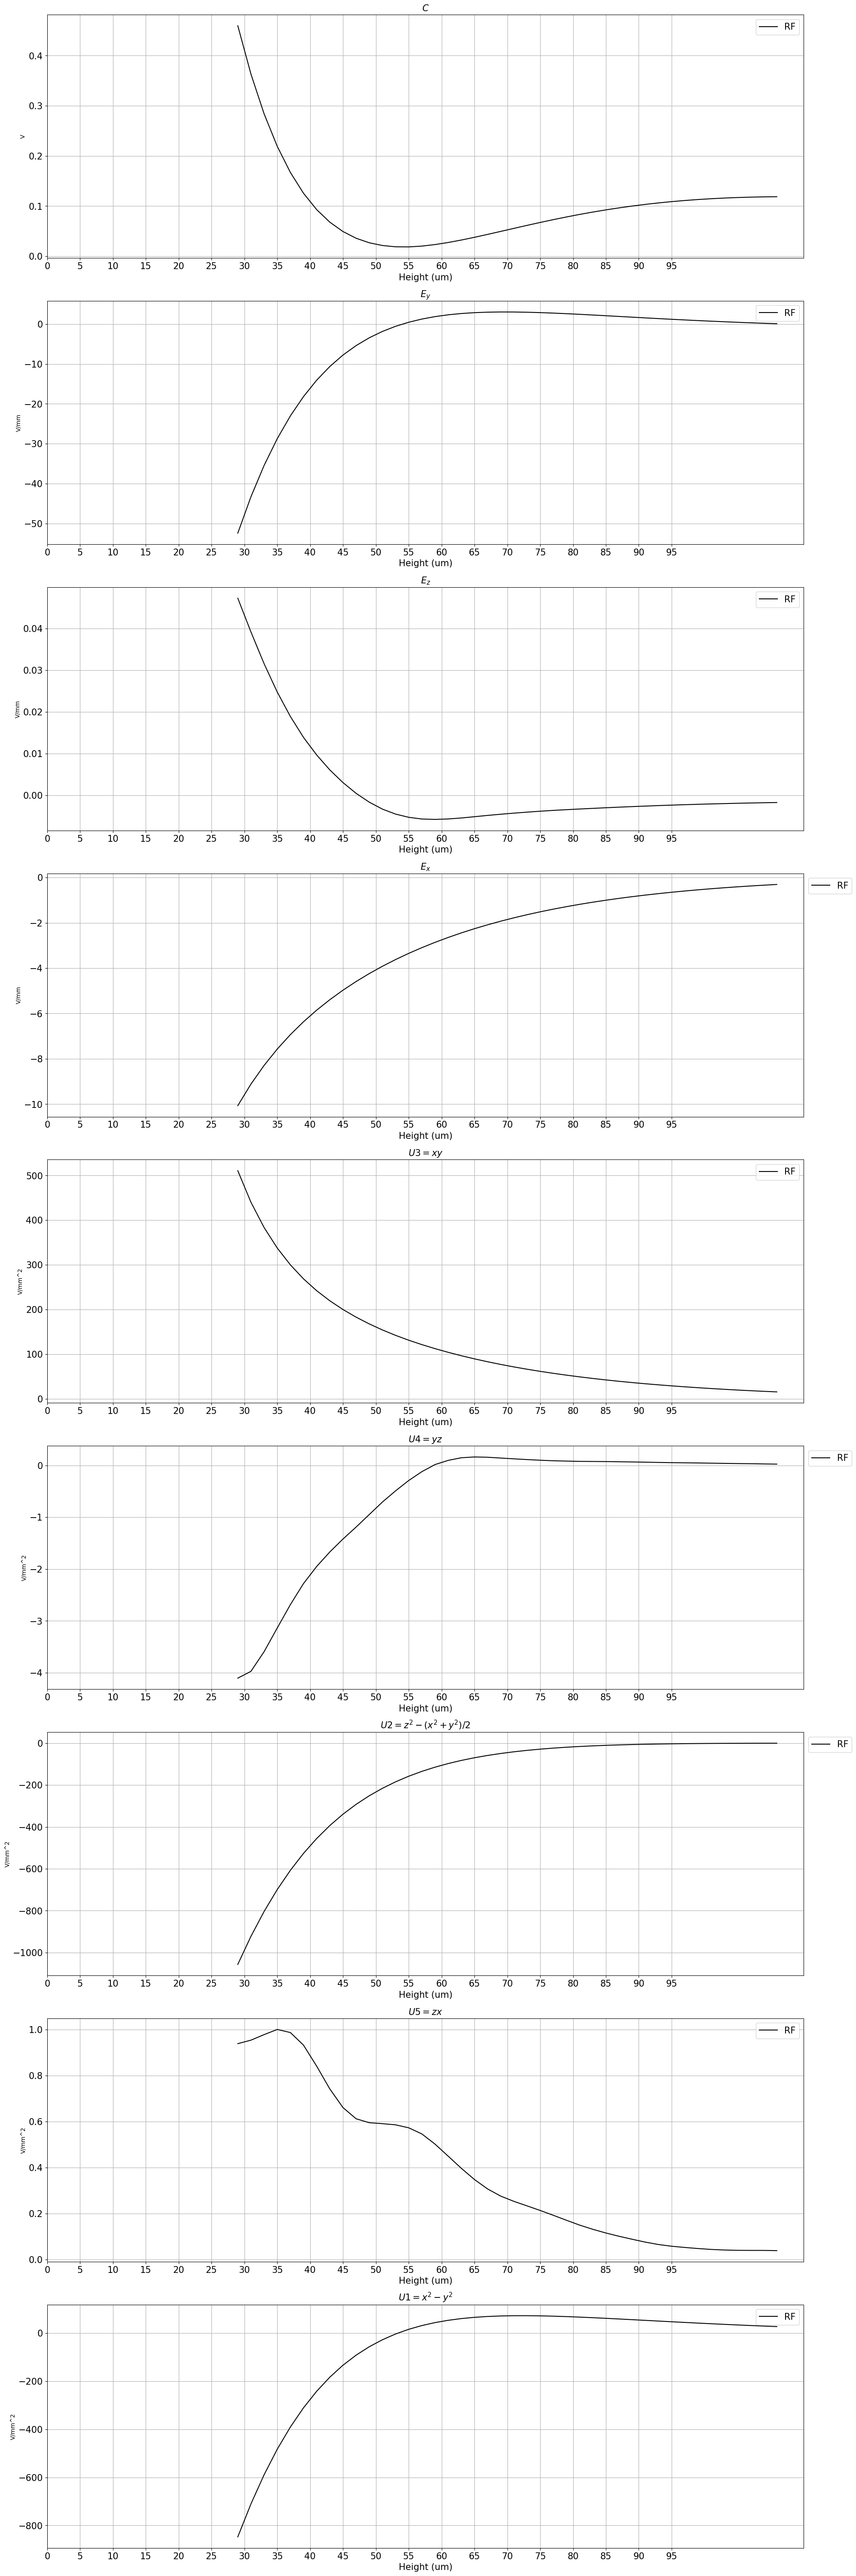

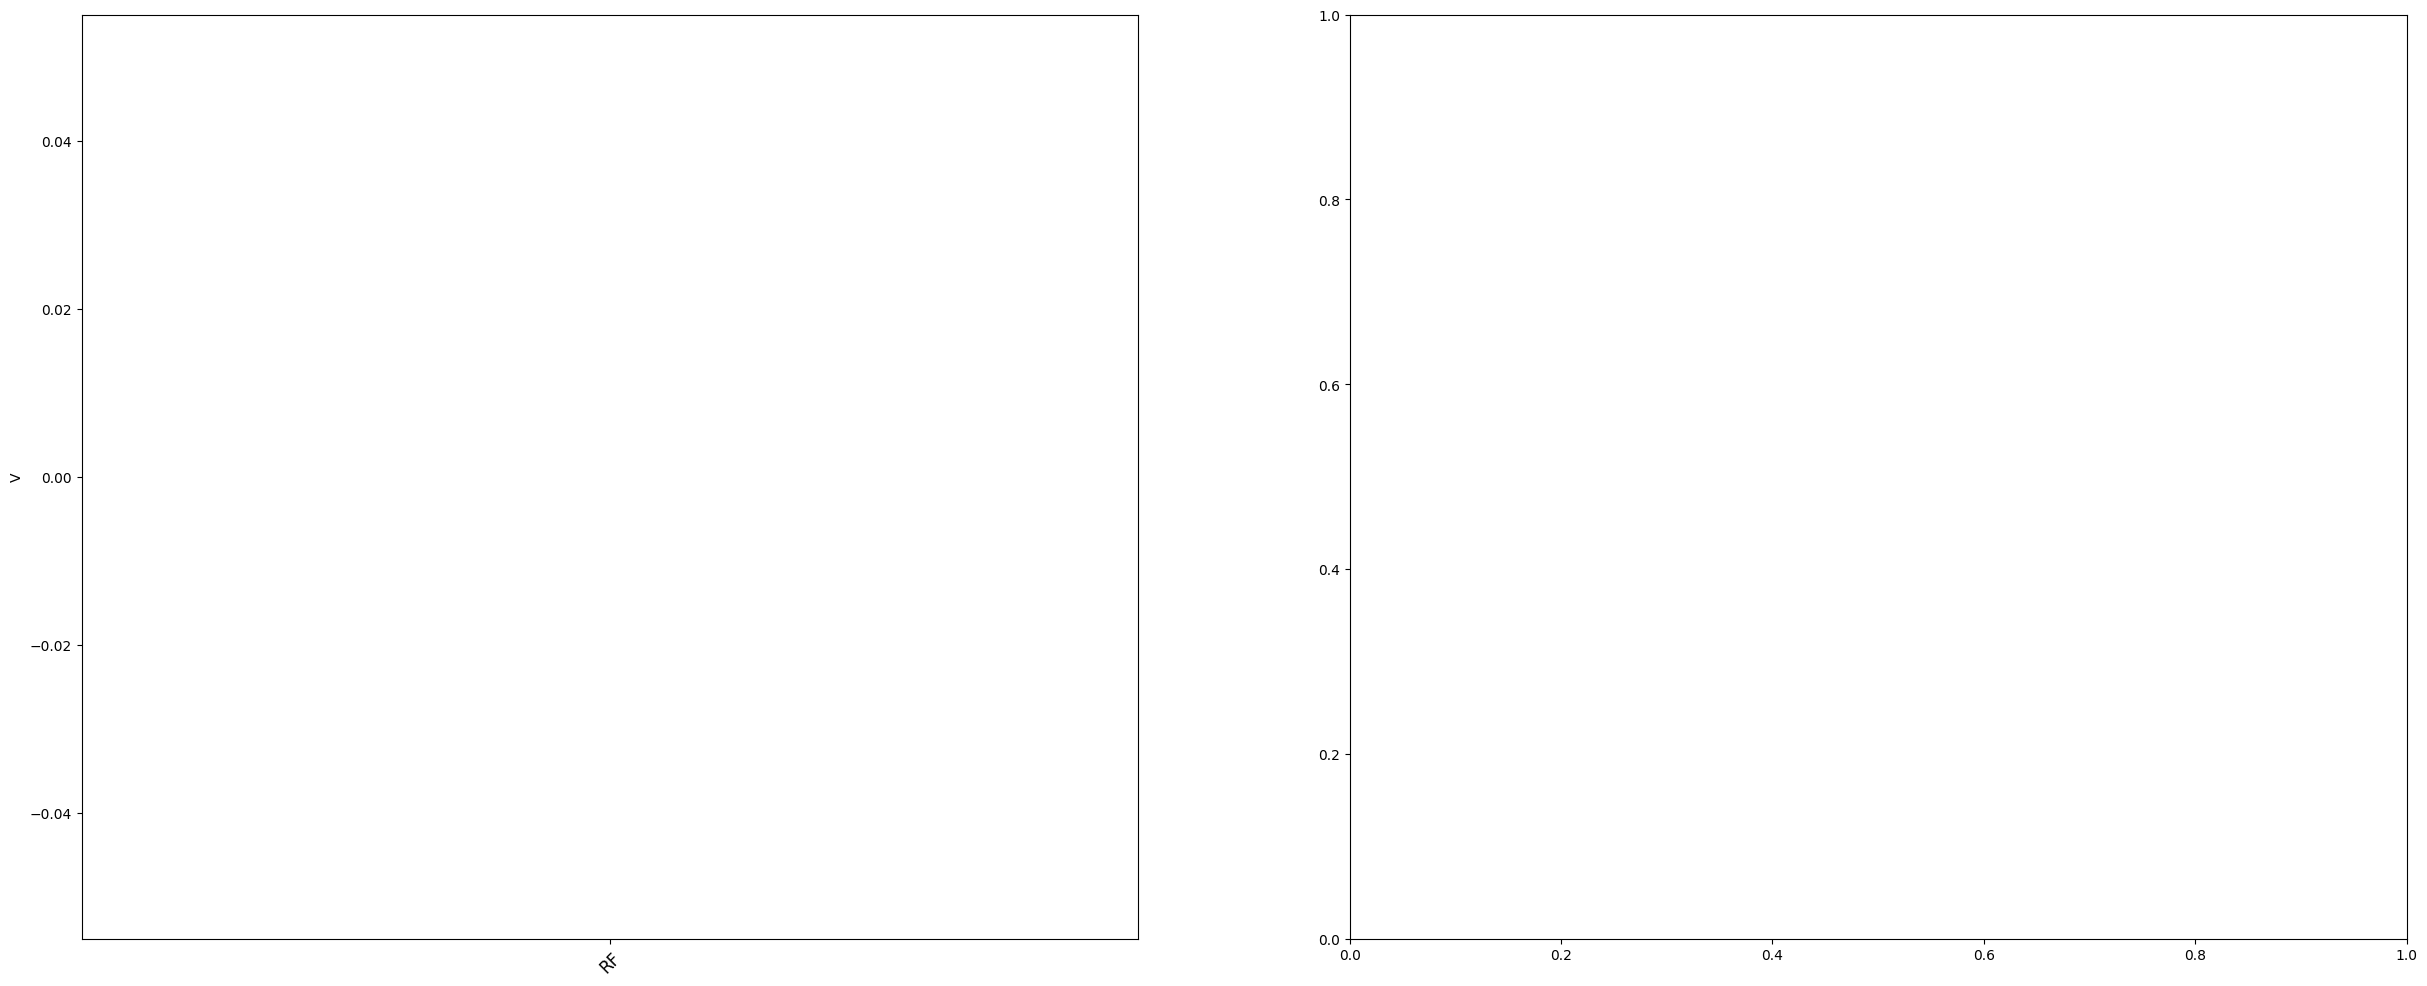

In [28]:
print(xl)
print(zl)
v1 = pd.Series(np.zeros(len(controlled_electrodes)), index=controlled_electrodes)
vs = []
height_list = trap['Y'][4:len(trap['Y'])-4]*1e3
height_list_ticks = np.arange(0,100,5)
for ele in s.electrode_names:
    v = v1.copy()
    v[ele] = 1
    vs.append(v)

# plot multipole coefficients vs different heights for each electrode

numMUltipoles = len(s.multipole_print_names)
ne = len(s.electrode_names)
multipoles_vs_height = np.zeros((len(height_list), numMUltipoles, ne))
print('height_list:',height_list)
for i, height in enumerate(height_list):
    position1 = [xl, height * 1e-3,zl]
    s.update_origin_roi(position1, roi)
    multipoles_vs_height[i] = s.multipole_expansion.loc[s.multipole_names]
# print(s.electrode_names[21])
size = 15
fig, ax = plt.subplots(numMUltipoles, 1, figsize=(20, 60))

for i, mul in enumerate(s.multipole_print_names):
    ax[i].set_prop_cycle(linestyle = ['-','-','-','-','-','--','--','--','--','--'],color= ['black','blue','purple','red','orange','black','blue','purple','red','orange'])
    for ele in ['RF']:
        j = s.electrode_names.index(ele)
        ax[i].plot(height_list, multipoles_vs_height[:, i, j], label=ele)
        ax[i].grid(visible=True)
        if i == 0:
            ax[i].set_ylabel('V')
        elif i < 4:
            ax[i].set_ylabel('V/mm')
        else:
            ax[i].set_ylabel('V/mm^2')
#         ax[i].set_ylim(-np.max(multipoles_vs_height[:, i, j])*1.2,np.max(multipoles_vs_height[:, i, j])*1.2)
        ax[i].set_title(mul, fontsize=size)
        ax[i].set_xticks(height_list_ticks)
        #         ax[i].set_xlim(left=50, right=100)
        ax[i].tick_params(labelsize=size)
        ax[i].set_xlabel('Height (um)', fontsize=size)
#     update_colors(ax[i])
    ax[i].legend(fontsize=size, bbox_to_anchor=(1, 1))

fig.canvas.draw()
fig.tight_layout(pad=1)

plot_muls(s,xl,zl,roi,height= 75, ez=0, ex=0, ey=0,u2=10, u5=0, u1=0, u3=0)
# %% md
# plot coefficients can be achieved for each multipole (controlled individually) when apply max 40 volts
# %%
numMUltipoles = len(used_multipoles)
Coeffs = pd.DataFrame()
for height in height_list:
    position1 = [xl, height*1e-3,zl]
    s.update_origin_roi(position1, roi)

    Coeffs_temp = pd.Series(dtype=float)
    for key in used_multipoles:
        multipole_coeffs = pd.Series(np.zeros(len(used_multipoles)), index=used_multipoles)
        multipole_coeffs[key] = 1
        voltages = s.setMultipoles(multipole_coeffs)
        max_v = np.max(abs(voltages))
        Coeffs_temp[key] = 30 / max_v

    Coeffs[height] = Coeffs_temp

size = 25
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))
 

for mul in used_order1multipoles:
    ax1.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax1.set_yscale('log')
ax1.set_ylabel(r'1st order multipoles $(V/mm)$', fontsize=size)
ax1.set_xticks(height_list_ticks)
ax1.set_xlabel('Axial location (um)', fontsize=size)
ax1.tick_params(labelsize=size,which='minor')
ax1.legend(fontsize=size)
ax1.set_ylim(1, 100)  # set ylim


ax1.grid(which='both')

for mul in used_order2multipoles:
    ax2.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax2.set_ylabel(r'2nd order multipoles $(V/mm^2)$', fontsize=size)
ax2.set_xticks(height_list_ticks)
ax2.set_xlabel('Axial Location (um)', fontsize=size)

ax2.set_ylim(1, 1000)  # set ylim
# ax2.set_yscale('log')
# ax2.set_tick_params(axis='y', which='minor')
ax2.tick_params(labelsize=size)
ax2.legend(fontsize=size)
ax2.grid(which='both')
fig.suptitle('Multipole coefficients: Max elecrode voltage 30V (MIT LL)', fontsize=size)
fig.tight_layout(pad=1)

secax = ax2.secondary_yaxis('right', functions=(U2_to_mhz, mhz_to_U2))
secax.tick_params(labelsize=size, colors='#ff7f0e')
secax.set_ylabel('$Ca^{+}$ trap frequency (MHz)', fontsize=size, color='#ff7f0e')

# plt.savefig('Multipole_coeffs_20v_rfbias.jpg', format = 'jpg', dpi = 300)

# plot_1d(s,xl,zl,roi,height=75, ez=0, ex=0, ey=0, u2=10,u5=0, u1=0, u3=0)
# %%
outarray = []

# plot_U2(s,xl,zl,roi,height=50.00, ez=0, ex=0, ey=0, u2=10, u5=0, u1=0, u3=0)
# output = interactive_plot.children[-1]
# output.layout.height = '1000px'


4
[-5.20510049e-02  1.54459778e-12 -6.79309311e-14  1.17640083e-13
 -1.32869410e-13  3.22403128e-13  1.00000000e+01  6.10838420e-14
 -8.69393446e-12]


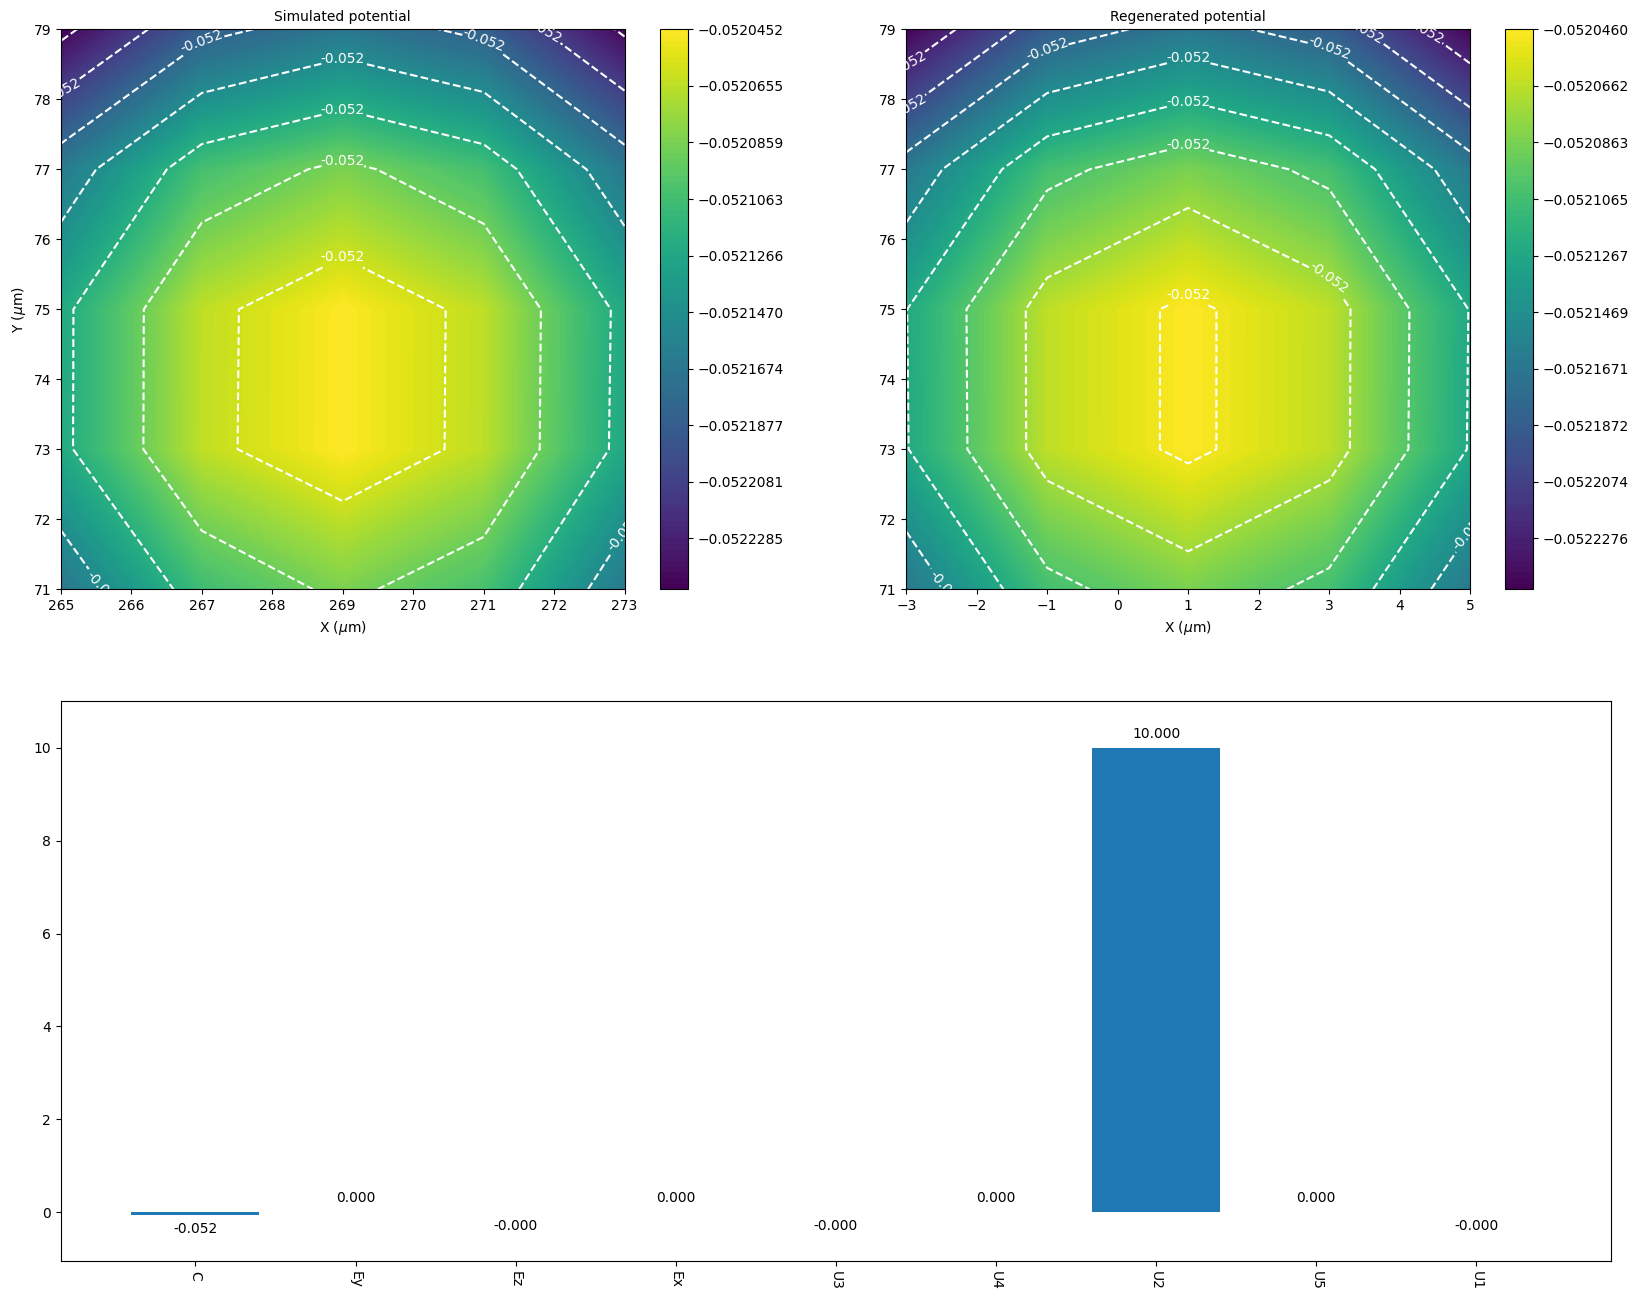

In [ ]:
import matplotlib as mpl
mpl.rc('xtick', labelsize=10) 
mpl.rc('ytick', labelsize=10) 
# plot_U2(s,xl,zl,roi,height=50.00, ez=0, ex=0, ey=0, u2=10, u5=0, u1=0, u3=0)
def plot_U21(s,xl,zl,roi,height, ey, ez, ex, u3, u2, u5, u1,view='zy'):
    position1 = [xl, height * 1e-3, zl]
    s.update_origin_roi(position1, roi)
    multipole_coeffs = {'Ey': ey, 'Ez': ez, 'Ex': ex, 'U3': u3, 'U2': u2, 'U5': u5, 'U1': u1}
    voltages = s.setMultipoles(multipole_coeffs)
    potential_roi = s.potentialControl_roi(voltages)
    potential_regen = s.potentialControl_regen(voltages)
    # nearestZ = find_nearest(s.Z, height * 1e-3)
    # indNearestZ_roi = np.abs(s.Z_roi - nearestZ).argmin()
    if view == 'zy':
        nearestX = find_nearest(s.X, xl)
        indNearestX_roi = np.abs(s.X_roi - nearestX).argmin()
        print(indNearestX_roi)
        print(np.shape(potential_roi))
        potential_xy_roi = potential_roi[indNearestX_roi]
        potential_xy_regen = potential_regen[indNearestX_roi]
    else:
        nearestZ = find_nearest(s.Z, zl)
        indNearestZ_roi = np.abs(s.Z_roi - nearestZ).argmin()
        potential_xy_roi = potential_roi[:,:,indNearestZ_roi]
        potential_xy_regen = potential_regen[:,:,indNearestZ_roi]
    fsize = 10

    fig1 = plt.figure(figsize=(20, 16))
    grid = plt.GridSpec(2, 2)
    ax1 = fig1.add_subplot(grid[0, 0])
    ax2 = fig1.add_subplot(grid[0, 1])
    ax3 = fig1.add_subplot(grid[1, :])
    ax1.set_title('Simulated potential', fontsize=fsize)
    levels1 = np.linspace(np.amin(potential_xy_roi), np.amax(potential_xy_roi), 100)
    plot1 = ax1.contourf(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_roi, levels1, cmap=plt.cm.viridis)
    plot1_line = ax1.contour(s.Z_roi * 1e3, s.Y_roi * 1e3, potential_xy_roi, colors='w')
    #     ax1.clabel(plot1_line, inline = 1, fontsize = fsize)
    ax1.clabel(plot1_line, colors='w', fmt='%2.3f', fontsize=fsize)
    ax1.set_xlabel('X ($\mu$m)', fontsize=fsize)
    ax1.set_ylabel('Y ($\mu$m)', fontsize=fsize)
    plt.colorbar(plot1, ax=ax1)

    ax2.set_title('Regenerated potential', fontsize=fsize)
    levels2 = np.linspace(np.amin(potential_xy_regen), np.amax(potential_xy_regen), 100)
    plot2 = ax2.contourf(s.X_roi * 1e3, s.Y_roi * 1e3, potential_xy_regen, levels2, cmap=plt.cm.viridis)
    plot2_line = ax2.contour(s.X_roi * 1e3, s.Y_roi * 1e3, potential_xy_regen, colors='w')
    #     ax2.clabel(plot2, inline = 1, fontsize = fsize)
    ax2.clabel(plot2_line, colors='w', fmt='%2.3f', fontsize=fsize)
    ax2.set_xlabel('X ($\mu$m)', fontsize=fsize)
    plt.colorbar(plot2, ax=ax2)

    coeffs = s.setVoltages(voltages)
    print(np.asarray(coeffs[0:9]))
    #     print(coeffs.index)
    ax3.bar(np.arange(9), np.asarray(coeffs)[0:9])
    max_coeff = np.max(coeffs[0:9])
    min_coeff = np.min(coeffs[0:9])
    margin = (max_coeff - min_coeff) * 0.1
    ymax = max_coeff + margin
    ymin = min_coeff - margin
    ax3.set_ylim(ymin, ymax)
    add_value_labels(ax3)
    ax3.set_xticks(np.arange(9))
    ax3.set_xticklabels(s.multipole_names, rotation=-90, fontsize=fsize)
    plt.show()
print(s.order)
plot_U21(s,xl,zl,roi,height=75.00, ez=0, ex=0, ey=0, u2=10, u5=0, u1=0, u3=0,view = 'xy')
# plot_U2(s,xl,zl,roi,height=50.00, ez=0, ex=0, ey=0, u2=10, u5=0, u1=0, u3=0,view = 'xy')
# output = interactive_plot.children[-1]
# output.layo

Text(0, 0.5, '$Ca^{+}$ trap frequency (MHz)')

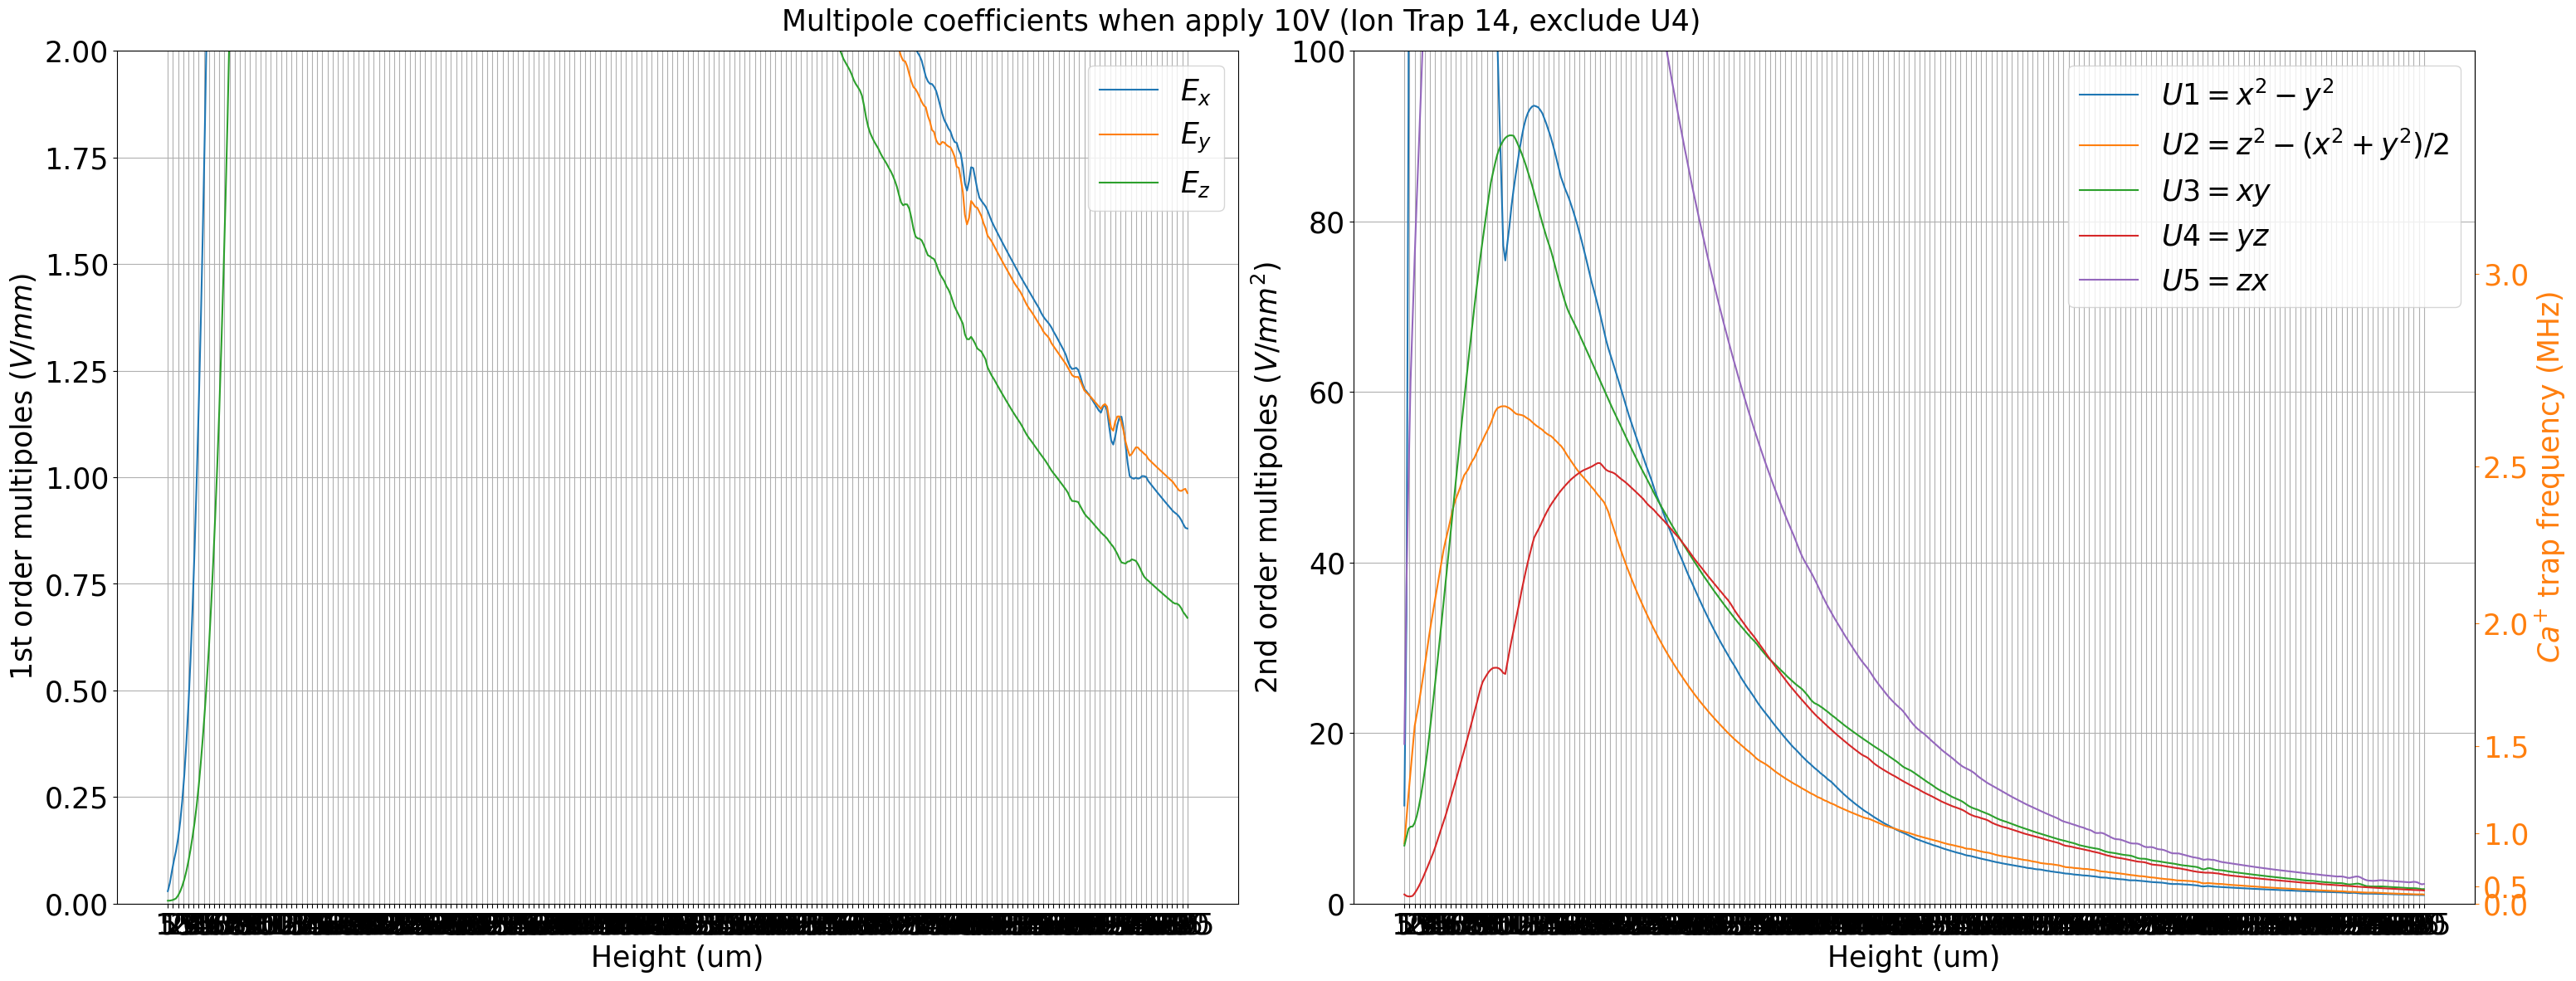

In [22]:
# %% md
# plot coefficients can be achieved for each multipole (controlled individually) when apply max 40 volts
# %%
excl = {
    # "DC6": "gnd",
    #     "DC4": "gnd",
        # "DC5": "gnd",
    #     "DC8": "gnd",
    #     "DC14": "DC13",
        # "DC11": "gnd",
        # "DC12": "gnd",
#     "DC1": "gnd",
#     "DC19": "gnd",
    "RF":"gnd"
}
# generate_s(excl)
numMUltipoles = len(used_multipoles)

size = 25
plt.rc('xtick', labelsize=size)    # fontsize of the tick labels
plt.rc('ytick', labelsize=size)    # fontsize of the tick labels
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(30, 12))


for mul in used_order1multipoles:
    ax1.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax1.set_ylabel(r'1st order multipoles $(V/mm)$', fontsize=size)
ax1.set_xticks(np.arange(height_list[0], height_list[-1] + 1, 5))
ax1.set_xlabel('Height (um)', fontsize=size)
ax1.tick_params(labelsize=size)
ax1.legend(fontsize=size)

ax1.set_ylim(0, 2)  # set ylim

ax1.grid(True)

for mul in used_order2multipoles:
    ax2.plot(height_list, Coeffs.loc[mul], label=s.multipole_print_names[mul])
ax2.set_ylabel(r'2nd order multipoles $(V/mm^2)$', fontsize=size)
ax2.set_xticks(np.arange(height_list[0], height_list[-1] + 1, 5))
ax2.set_xlabel('Height (um)', fontsize=size)

ax2.set_ylim(0, 100)  # set ylim


ax2.tick_params(labelsize=size)
ax2.legend(fontsize=size)
ax2.grid(True)
fig.suptitle('Multipole coefficients when apply 10V (Ion Trap 14, exclude U4)', fontsize=size)
fig.tight_layout(pad=1)

secax = ax2.secondary_yaxis('right', functions=(U2_to_mhz, mhz_to_U2))
secax.tick_params(labelsize=size, colors='#ff7f0e')
secax.set_ylabel('$Ca^{+}$ trap frequency (MHz)', fontsize=size, color='#ff7f0e')